In [1]:
# allow to import modules from the project root directory
import sys
import os
# Add the project root directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..')))

In [2]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import random
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from src.ParObsSnakeEnv import SnakeEnv
import torch.nn.functional as F

In [3]:
class Actor(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(Actor, self).__init__()
        self.num_actions = num_actions
        self.Dropout = nn.Dropout(p=0.4)
        self.fc1 = nn.Linear(num_inputs, 128)
        self.fc2 = nn.Linear(128, num_actions)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = self.Dropout(x)
        logits = self.fc2(x)
        return logits
    
    def choose_action(self, state):
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        logits = self.forward(state_tensor)
        action_probs = F.softmax(logits, dim=1)
        action = np.random.choice(self.num_actions, p=action_probs.detach().numpy()[0])
        return action, action_probs

class Critic(nn.Module):
    def __init__(self, num_inputs):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(num_inputs, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        value = self.fc2(x)
        return value

In [4]:
env = SnakeEnv(grid_size=10, interact=False)
num_actions = env.action_space.n
num_inputs = env.observation_space.shape[0]

In [5]:
gamma = 0.99
actor_lr = 0.0001
critic_lr = 0.0001
num_episodes = 3000

In [6]:
actor = Actor(num_inputs, num_actions)
critic = Critic(num_inputs)
criterion = nn.MSELoss()
episode_reward_list = list()

In [7]:
# Initialize optimizers and learning rate schedulers
actor_optimizer = torch.optim.Adam(actor.parameters(), lr=0.001)
critic_optimizer = torch.optim.Adam(critic.parameters(), lr=0.001)

In [8]:
# Training loop
for episode in tqdm(range(num_episodes), desc="Training Episodes"):
    state = env.reset()
    done = False
    episode_reward = 0

    while not done:
        action, action_probs = actor.choose_action(state)
        next_state, reward, done, _ = env.step(action)
        episode_reward += reward

        if done:
            reward = -1

        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)

        value = critic(state_tensor)
        next_value = critic(next_state_tensor)

        target_value = reward + gamma * next_value * (1 - int(done))
        advantage = target_value - value

        actor_loss = -torch.log(action_probs[0, action]) * advantage.item()
        critic_loss = criterion(value, target_value.detach())

        actor_optimizer.zero_grad()
        critic_optimizer.zero_grad()

        actor_loss.backward()
        critic_loss.backward()

        actor_optimizer.step()
        critic_optimizer.step()

        state = next_state

    episode_reward_list.append(episode_reward)

Training Episodes: 100%|██████████| 3000/3000 [07:49<00:00,  6.38it/s]


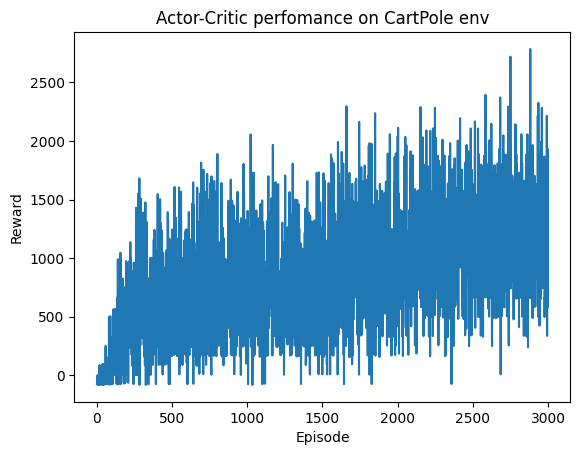

In [9]:
# Plot the Results
import matplotlib.pyplot as plt
plt.plot(episode_reward_list)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Actor-Critic perfomance on CartPole env')
plt.show()

In [ ]:
# Inference loop
env = SnakeEnv(grid_size=20)
state = env.reset()
done = False
while not done:
    with torch.no_grad():
        action, _ = actor.choose_action(state)
    state, reward, done, _ = env.step(action)
    env.render()
    print(f"Reward: {reward}")

Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 76
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 76
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 76
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 76
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 76
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 76
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 76
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Reward: 1
Rew

: 